
# Spherepop Playground Notebook

A minimal executable toy model of **Spherepop**:

- Spheres = delayed irreversible events  
- Pop = evaluates once and records history  
- History defines identity  
- Nested scopes = compositional structure  
- Simple visualizations of event-history geometry


## Imports and Core Data Structures

In [1]:
import uuid
from dataclasses import dataclass, field
from typing import Callable, Any, List, Tuple, Dict
import matplotlib.pyplot as plt

@dataclass
class Event:
    eid: str
    label: str
    value: Any
    parents: Tuple[str, ...]

@dataclass
class History:
    events: Dict[str, Event] = field(default_factory=dict)

    def add(self, event: Event):
        self.events[event.eid] = event

    def lineage(self, eid: str) -> List[str]:
        seen = set()
        order = []
        def dfs(x):
            if x in seen: return
            seen.add(x)
            for p in self.events[x].parents:
                dfs(p)
            order.append(x)
        dfs(eid)
        return order

@dataclass
class Sphere:
    label: str
    thunk: Callable[['History'], Any]
    _eid: str = None

    def pop(self, history: History) -> Tuple[Any, str]:
        if self._eid is not None:
            return history.events[self._eid].value, self._eid

        value, parents = self.thunk(history)
        eid = str(uuid.uuid4())
        history.add(Event(eid=eid, label=self.label, value=value, parents=parents))
        self._eid = eid
        return value, eid


## Primitive Constructors

In [2]:
def const(label, x):
    return Sphere(label, lambda h: (x, ()))

def add(label, a: Sphere, b: Sphere):
    def thunk(h):
        va, ea = a.pop(h)
        vb, eb = b.pop(h)
        return va + vb, (ea, eb)
    return Sphere(label, thunk)

def mul(label, a: Sphere, b: Sphere):
    def thunk(h):
        va, ea = a.pop(h)
        vb, eb = b.pop(h)
        return va * vb, (ea, eb)
    return Sphere(label, thunk)


## Example: `(1 + 2) * 3`

In [3]:
H = History()

s1 = const("one", 1)
s2 = const("two", 2)
s3 = const("three", 3)

s_add = add("add", s1, s2)
s_expr = mul("mul", s_add, s3)

value, root = s_expr.pop(H)
value, root


(9, 'dcaaac14-6b91-467f-9acc-baacb4444112')

## Identity by History

In [4]:
H2 = History()
a1 = const("one", 1)
a2 = const("two", 2)
a3 = const("three", 3)
expr2 = mul("mul", add("add", a1, a2), a3)
v2, root2 = expr2.pop(H2)

value, v2, root == root2


(9, 9, False)

## Visualize Event Graph Geometry

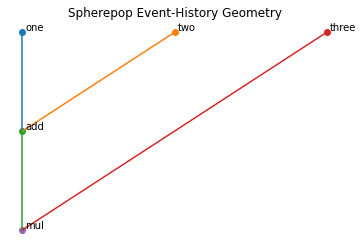

In [5]:
def depth(h: History, eid: str) -> int:
    e = h.events[eid]
    if not e.parents:
        return 0
    return 1 + max(depth(h, p) for p in e.parents)

nodes = list(H.events.keys())
depths = {eid: depth(H, eid) for eid in nodes}

layers = {}
for eid, d in depths.items():
    layers.setdefault(d, []).append(eid)

pos = {}
for d, eids in layers.items():
    for i, eid in enumerate(eids):
        pos[eid] = (i, -d)

plt.figure()
for eid, e in H.events.items():
    x, y = pos[eid]
    plt.scatter([x], [y])
    plt.text(x+0.02, y+0.02, e.label)
    for p in e.parents:
        xp, yp = pos[p]
        plt.plot([xp, x], [yp, y])

plt.title("Spherepop Event-History Geometry")
plt.axis('off')
plt.show()


## Nested Scopes as Reusable Sub-Spheres

In [6]:
H3 = History()
inner = add("inner_add", const("a", 4), const("b", 5))
outer1 = mul("outer1", inner, const("c", 10))
outer2 = mul("outer2", inner, const("d", 100))

v1, r1 = outer1.pop(H3)
v2, r2 = outer2.pop(H3)

v1, v2, len(H3.events)


(90, 900, 7)

## Trajectory View: Lineage of an Event

In [7]:
line = H3.lineage(r2)
[(H3.events[e].label, H3.events[e].value) for e in line]

[('a', 4), ('b', 5), ('inner_add', 9), ('d', 100), ('outer2', 900)]

## Radial Embedding of Causal Structure

This visualization embeds the event history into the plane by mapping causal
depth to radial distance from the origin. Angular positions are assigned to
separate branches, producing a geometric representation of the event partial
order.

The embedding is topological rather than metric and is intended to reveal
branching structure and reuse patterns.


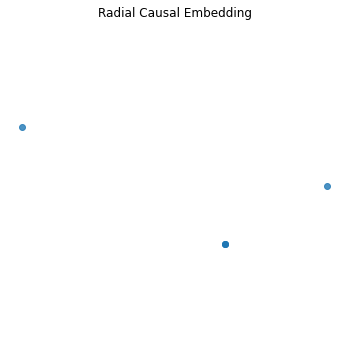

In [8]:
import math
import random

# find causal roots
roots = [eid for eid, e in H.events.items() if not e.parents]

angles = {}

def assign_angles(eid, theta):
    angles[eid] = theta
    children = [e.eid for e in H.events.values() if eid in e.parents]
    if not children:
        return
    spread = math.pi / max(1, len(children))
    for i, c in enumerate(children):
        assign_angles(c, theta + (i - len(children)/2)*spread)

for i, r in enumerate(roots):
    assign_angles(r, 2 * math.pi * i / max(1, len(roots)))

xs, ys = [], []
for eid in H.events:
    r = depth(H, eid)
    theta = angles.get(eid, random.uniform(-math.pi, math.pi))
    xs.append(r * math.cos(theta))
    ys.append(r * math.sin(theta))

plt.figure(figsize=(6,6))
plt.scatter(xs, ys, alpha=0.8)
plt.axis("equal")
plt.axis("off")
plt.title("Radial Causal Embedding")
plt.show()


## Causal Depth Heatmap

This heatmap represents causal depth as a scalar field over an abstract embedding
of events. Regions of higher intensity correspond to events with greater causal
depth, interpretable as accumulated irreversible computation.

The embedding is representational rather than physical; the heatmap is intended
to visualize gradients in event depth rather than metric distance.


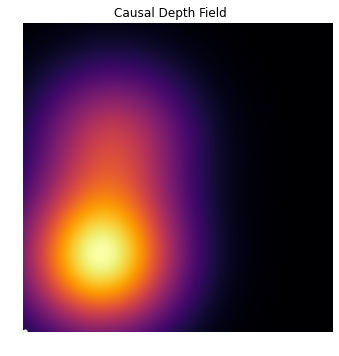

In [9]:
import numpy as np
import random

# assign stable pseudo-random positions to events
rng = np.random.default_rng(0)
event_ids = list(H.events.keys())
points = rng.normal(size=(len(event_ids), 2))

depth_vals = np.array([depth(H, eid) for eid in event_ids])

# grid
res = 300
x = np.linspace(points[:,0].min()-1, points[:,0].max()+1, res)
y = np.linspace(points[:,1].min()-1, points[:,1].max()+1, res)
xx, yy = np.meshgrid(x, y)
grid = np.stack([xx, yy], axis=-1)

# smooth field via radial basis influence
field = np.zeros((res, res))
for (px, py), d in zip(points, depth_vals):
    field += d * np.exp(-((xx-px)**2 + (yy-py)**2))

plt.figure(figsize=(6,6))
plt.imshow(field, origin="lower", cmap="inferno")
plt.scatter(points[:,0], points[:,1], c="white", s=10)
plt.title("Causal Depth Field")
plt.axis("off")
plt.show()


## Event Reuse Heatmap

This heatmap visualizes the reuse of events by encoding fan-out (number of
descendants) as a continuous field. Events that support many downstream
computations generate larger or more intense regions.

This representation highlights structurally load-bearing events within the
history.


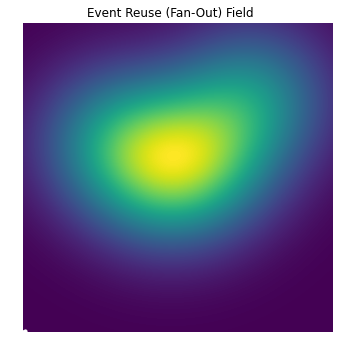

In [10]:
# compute fan-out
fan_out = {eid: 0 for eid in H.events}
for e in H.events.values():
    for p in e.parents:
        fan_out[p] += 1

fan_vals = np.array([fan_out[eid] for eid in event_ids])

field = np.zeros((res, res))
for (px, py), f in zip(points, fan_vals):
    field += f * np.exp(-((xx-px)**2 + (yy-py)**2))

plt.figure(figsize=(6,6))
plt.imshow(field, origin="lower", cmap="viridis")
plt.scatter(points[:,0], points[:,1], c="white", s=10)
plt.title("Event Reuse (Fan-Out) Field")
plt.axis("off")
plt.show()


## Lineage Density Heatmap

This heatmap represents the density of causal lineages passing through regions
of the embedding. Multiple event lineages are sampled and superimposed to reveal
areas of frequent causal traversal.

High-density regions indicate shared ancestry and semantic convergence.


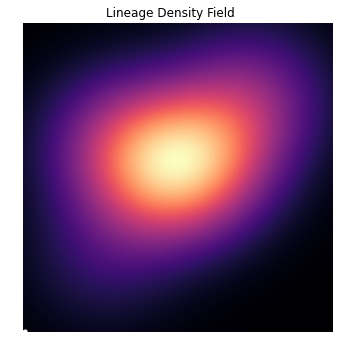

In [11]:
import random

field = np.zeros((res, res))

# sample several lineages
samples = random.sample(event_ids, min(5, len(event_ids)))

for eid in samples:
    for a in H.lineage(eid):
        idx = event_ids.index(a)
        px, py = points[idx]
        field += np.exp(-((xx-px)**2 + (yy-py)**2))

plt.figure(figsize=(6,6))
plt.imshow(field, origin="lower", cmap="magma")
plt.scatter(points[:,0], points[:,1], c="white", s=10)
plt.title("Lineage Density Field")
plt.axis("off")
plt.show()


## Gradient Flow of Causal Depth

In this visualization, causal depth is treated as a scalar potential over an
abstract embedding of events. The gradient of this field defines a vector flow
indicating the direction of increasing causal accumulation.

This representation makes explicit the notion of *causal descent* and provides
a geometric analogue of information flow within the event history.


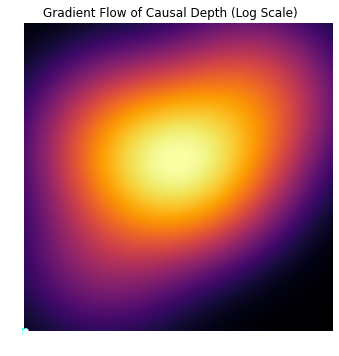

In [13]:
# log-compress the scalar field
field_log = np.log1p(field)

gy, gx = np.gradient(field_log)

plt.figure(figsize=(6,6))
plt.imshow(field_log, origin="lower", cmap="inferno")
plt.quiver(X, Y, gx[::step,::step], gy[::step,::step],
           color="cyan", scale=40)
plt.scatter(points[:,0], points[:,1], c="white", s=10)
plt.title("Gradient Flow of Causal Depth (Log Scale)")
plt.axis("off")
plt.show()


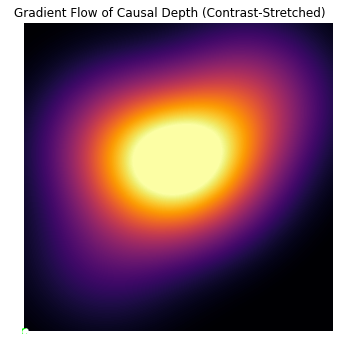

In [14]:
# contrast stretch
lo, hi = np.percentile(field, [5, 95])
field_cs = np.clip(field, lo, hi)

gy, gx = np.gradient(field_cs)

plt.figure(figsize=(6,6))
plt.imshow(field_cs, origin="lower", cmap="inferno")
plt.quiver(X, Y, gx[::step,::step], gy[::step,::step],
           color="lime", scale=35)
plt.scatter(points[:,0], points[:,1], c="white", s=10)
plt.title("Gradient Flow of Causal Depth (Contrast-Stretched)")
plt.axis("off")
plt.show()
